# 2018-05-11 - Représenter l'information sur une image naturelle
*L'entropie mesure l'incertitude dans un processus stochastique : plus un objet est incertain plus il est entropique. En image, on peut s'attendre à ce que les zones avec le plus de variances soient celles qui possèdent le plus d'entropie.*
Dans l'objectif d'intégrer des saccades au modèle, on intègre une mesure d'information dans l'image pour regarder les zones qui sont les plus informatives en premier.

Essayons sur une photo du lac Myvatn, en Islande :

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage


def calculate_entropy(signal):
    probabability_distribution = [np.size(signal[signal == i])/(1.0 * signal.size) for i in list(set(signal))]
    entropy = np.sum([pp * np.log2(1.0 / pp) for pp in probabability_distribution])
    return entropy

#on utilise une image qu'on transforme en greyscale avec un calcul d'entropie dans la zone
def image_entropy(img, size = 5, reshape_width = 500):
    image = Image.open(img)
    
    #reshape l'image en reshape_width*hsize, proportionnellement
    wpercent = (reshape_width / float(image.size[0]))
    hsize = int((float(image.size[1]) * float(wpercent)))
    image = image.resize((reshape_width, hsize), Image.ANTIALIAS)
    print('Image reshaped to %s x %s' % (reshape_width, hsize))
    
    image_grey = image.convert('L')

    #simplifie les étapes suivantes
    image = np.array(image)
    image_grey = np.array(image_grey)

    #définir la zone dans laquelle on calcule, de (size*2) x (size*2)
    rows, cols = image_grey.shape
    entropy = np.array(image_grey) #dummy var
    
    for row in range(rows) :
        for col in range(cols):
            lower_x = np.max([0, col - size])
            upper_x = np.min([cols, col + size])
            lower_y = np.max([0, row - size])
            upper_y = np.min([rows, row + size])

            area = image_grey[lower_y: upper_y, lower_x: upper_x].flatten()
            
            entropy[row,col] = calculate_entropy(area)
            
    return entropy  

On calcule et on affiche :
![Cannot display color map](https://matplotlib.org/_images/colormaps_reference_00.png)

Image reshaped to 500 x 375
Image reshaped to 500 x 375


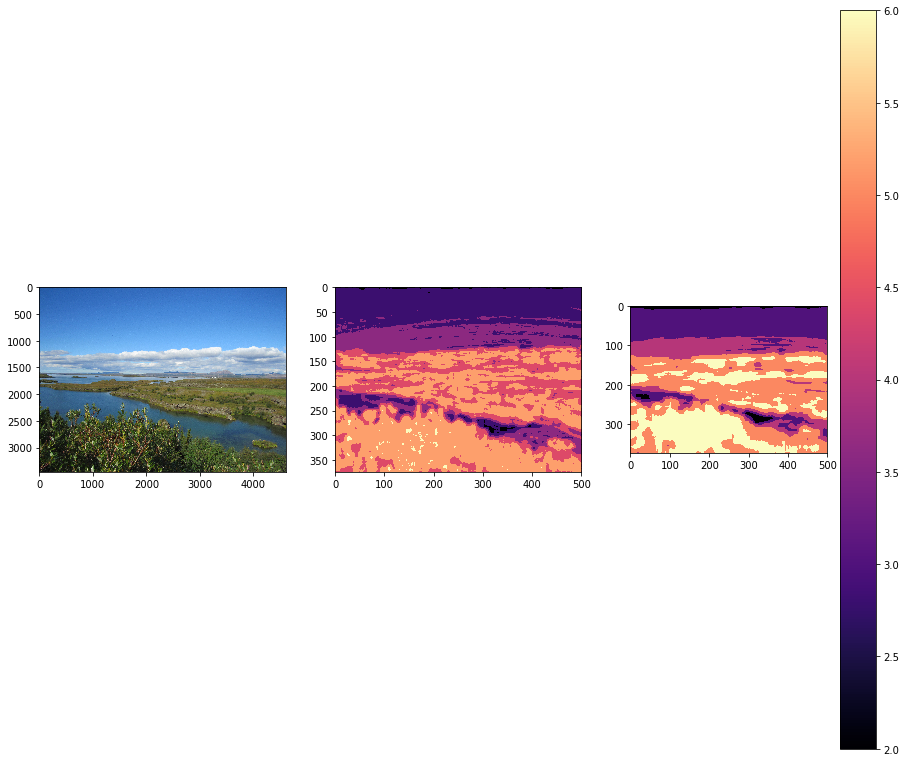

In [176]:
image = Image.open('myvatn.JPG')
image_entropy_values_5 = image_entropy('myvatn.JPG', size = 5)
image_entropy_values_10 = image_entropy('myvatn.JPG', size = 10)

plt.rcParams["figure.figsize"] = [15, 15]

plt.subplot(1,3,1)
plt.imshow(image)

plt.subplot(1,3,2)
plt.imshow(image_entropy_values_5, cmap = plt.cm.magma)

plt.subplot(1,3,3)
plt.imshow(image_entropy_values_10, cmap = plt.cm.magma)

Maintenant qu'on a les maps d'entropie de l'image on va orienter les saccades vers la zone avec la plus d'entropie. Comme le réseau de la W1 était entrainé à classifier du 32x32, on va chercher la zone 32x32 avec la plus forte valeur d'entropie :

Maximum entropy zone index : 149
Maximum entropy zone array and coordinates:
 [[5 5 5 ... 5 5 5]
 [5 5 5 ... 5 5 5]
 [5 5 5 ... 5 5 5]
 ...
 [5 5 5 ... 5 5 5]
 [5 5 5 ... 5 5 5]
 [5 5 5 ... 5 5 5]] - (288, 320, 160, 192)


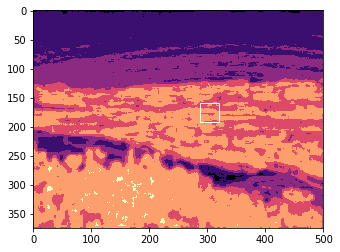

In [193]:
import math 
import matplotlib.patches as patches
%matplotlib inline

sub_list = [] #holds the splitted image
coordinate_list = [] #holds the coordinate to display max_entropy zone
sum_list = [] #holds the np array sums

#split the image into 32*32 images
nb_cut_h, nb_cut_w = image_entropy_values_5.shape
nb_cut_h /= 32
nb_cut_w /= 32

#split
for x in range (math.ceil(nb_cut_h)) :
    for y in range (math.ceil(nb_cut_w)):
        sub_img = image_entropy_values_5[x*32:(x*32)+32,
                                         y*32:(y*32)+32]
        coordinate_list.append((x*32,(x*32)+32,
                                         y*32,(y*32)+32))
        sub_list.append(sub_img)

#find the maximum entropy subarray    
for x in sub_list :
    sum_x = np.sum(x)
    sum_list.append(sum_x)


max_entropy_index = [i for i, j in enumerate(sum_list) if j == max(sum_list)][0]

print("Maximum entropy zone index : %s" % max_entropy_index)
print("Maximum entropy zone array and coordinates:\n %s - %s" % (sub_list[max_entropy_index],
                                                                 coordinate_list[max_entropy_index]))

#plot
fig,ax = plt.subplots(1)
ax.imshow(image_entropy_values_5, cmap = plt.cm.magma)
max_entropy_zone = patches.Rectangle((coordinate_list[max_entropy_index][0],
                                      coordinate_list[max_entropy_index][2]),
                                     32,32, linewidth = 1, edgecolor = 'white',facecolor = 'none')
ax.add_patch(max_entropy_zone)
plt.show()
